# Phase 5: Feature Importance and Reduction
Tori St. John - December 2025

## Loading everything up again

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import os

print('TensorFlow version:', tf.__version__)

os.makedirs('plots', exist_ok=True)

TensorFlow version: 2.16.2


In [6]:
# same data loading as before
csv_path = "data/cardio_train 2.csv"
df = pd.read_csv(csv_path, sep=";")
print('Original shape:', df.shape)

Original shape: (70000, 13)


In [7]:
# cleaning - removing the weird blood pressure values
df = df[(df['ap_hi'] > 0) & (df['ap_hi'] < 300)]
df = df[(df['ap_lo'] > 0) & (df['ap_lo'] < 200)]
df = df[df['ap_hi'] > df['ap_lo']]
print('After cleaning:', df.shape)

After cleaning: (68709, 13)


In [8]:
# my 11 features
feature_cols = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
                'cholesterol', 'gluc', 'smoke', 'alco', 'active']
print(f'Features: {feature_cols}')

Features: ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']


In [9]:
X = df[feature_cols].values
Y = df['cardio'].values

print('X shape:', X.shape)
print('Y shape:', Y.shape)

X shape: (68709, 11)
Y shape: (68709,)


In [10]:
# shuffle and split same as phase 4
dataset = np.column_stack((X, Y))
np.random.seed(42)
np.random.shuffle(dataset)

index_20percent = int(0.2 * len(dataset))

XVALIDATION_FULL = dataset[:index_20percent, :-1]
YVALIDATION = dataset[:index_20percent, -1]
XTRAIN_FULL = dataset[index_20percent:, :-1]
YTRAIN = dataset[index_20percent:, -1]

print('Training samples:', XTRAIN_FULL.shape[0])
print('Validation samples:', XVALIDATION_FULL.shape[0])

Training samples: 54968
Validation samples: 13741


## Part 1: Testing each feature by itself
The idea here is to train a model using only ONE feature at a time.
Whichever feature gives the best accuracy by itself is probably the most important.

In [11]:
def train_single_feature(feature_idx, feature_name, X_train, Y_train, X_val, Y_val):
    """trains a small model using just one feature"""

    # grab just this one column
    X_train_single = X_train[:, feature_idx].reshape(-1, 1)
    X_val_single = X_val[:, feature_idx].reshape(-1, 1)

    # normalize it
    mean = X_train_single.mean()
    std = X_train_single.std()
    if std == 0:
        std = 1  # just in case

    X_train_norm = (X_train_single - mean) / std
    X_val_norm = (X_val_single - mean) / std

    # simple model - 8 neurons, 1 output
    model = Sequential()
    model.add(Dense(8, input_dim=1, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # checkpointing like we did in phase 4
    checkpoint_path = f'single_{feature_name}.weights.h5'
    callback_a = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',
                                  save_best_only=True, save_weights_only=True, verbose=0)
    callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=0)

    model.fit(X_train_norm, Y_train,
              validation_data=(X_val_norm, Y_val),
              epochs=50, batch_size=128,
              callbacks=[callback_a, callback_b], verbose=0)

    # load best weights
    model.load_weights(checkpoint_path)
    scores = model.evaluate(X_val_norm, Y_val, verbose=0)

    return scores[1]

In [12]:
# train a model for each feature
print("Testing each feature individually...")
print("-" * 40)

single_accuracies = {}

for i, feat in enumerate(feature_cols):
    acc = train_single_feature(i, feat, XTRAIN_FULL, YTRAIN, XVALIDATION_FULL, YVALIDATION)
    single_accuracies[feat] = acc
    print(f'{feat}: {acc*100:.2f}%')

Testing each feature individually...
----------------------------------------


/Users/victoriast.john/.pyenv/versions/3.11.13/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


age: 59.25%
gender: 50.59%
height: 50.96%
weight: 57.91%
ap_hi: 71.12%
ap_lo: 66.20%
cholesterol: 58.85%
gluc: 53.54%
smoke: 50.59%
alco: 50.59%
active: 51.98%


In [13]:
# sort them to see which ones are best
sorted_features = sorted(single_accuracies.items(), key=lambda x: x[1], reverse=True)

print("\nRanked from most to least important:")
for i, (feat, acc) in enumerate(sorted_features, 1):
    print(f'{i}. {feat}: {acc*100:.2f}%')


Ranked from most to least important:
1. ap_hi: 71.12%
2. ap_lo: 66.20%
3. age: 59.25%
4. cholesterol: 58.85%
5. weight: 57.91%
6. gluc: 53.54%
7. active: 51.98%
8. height: 50.96%
9. gender: 50.59%
10. smoke: 50.59%
11. alco: 50.59%


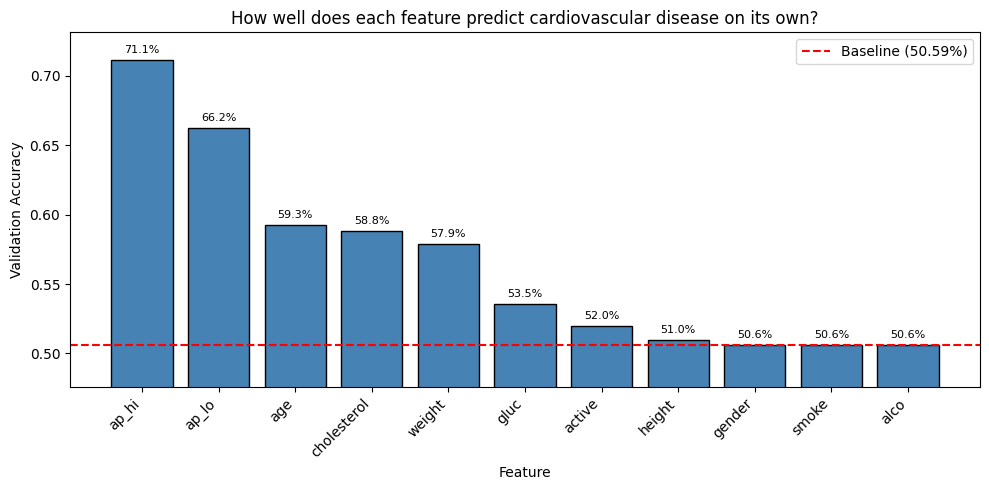

In [14]:
# plot it
plt.figure(figsize=(10, 5))
features_sorted = [f[0] for f in sorted_features]
accs_sorted = [f[1] for f in sorted_features]

plt.bar(features_sorted, accs_sorted, color='steelblue', edgecolor='black')
plt.xlabel('Feature')
plt.ylabel('Validation Accuracy')
plt.title('How well does each feature predict cardiovascular disease on its own?')
plt.xticks(rotation=45, ha='right')

# zoom in on the relevant range
min_acc = min(accs_sorted)
plt.ylim([min_acc - 0.03, max(accs_sorted) + 0.02])

# add the percentages on top
for i, (feat, acc) in enumerate(zip(features_sorted, accs_sorted)):
    plt.text(i, acc + 0.005, f'{acc*100:.1f}%', ha='center', fontsize=8)

plt.axhline(y=0.5059, color='red', linestyle='--', label='Baseline (50.59%)')
plt.legend()
plt.tight_layout()
plt.savefig('plots/single_feature_importance.png', dpi=150)
plt.show()

## Part 2: Removing features one at a time
Now I'll start with all 11 features and remove the worst one, then the next worst, etc.
This shows if we can get similar accuracy with fewer features.

In [15]:
# order features from worst to best (so I remove worst first)
features_worst_to_best = [f[0] for f in reversed(sorted_features)]
print("Order I'll remove them:", features_worst_to_best)

Order I'll remove them: ['alco', 'smoke', 'gender', 'height', 'active', 'gluc', 'weight', 'cholesterol', 'age', 'ap_lo', 'ap_hi']


In [16]:
def train_with_features(feature_list, name, X_train, Y_train, X_val, Y_val):
    """train the 8-1 model with whatever features are passed in"""

    # get the column indices for these features
    indices = [feature_cols.index(f) for f in feature_list]

    X_tr = X_train[:, indices]
    X_va = X_val[:, indices]

    # normalize
    mean = X_tr.mean(axis=0)
    std = X_tr.std(axis=0)
    std[std == 0] = 1

    X_tr_norm = (X_tr - mean) / std
    X_va_norm = (X_va - mean) / std

    # 8-1 model like phase 4
    model = Sequential()
    model.add(Dense(8, input_dim=len(feature_list), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    checkpoint_path = f'{name}.weights.h5'
    callback_a = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',
                                  save_best_only=True, save_weights_only=True, verbose=0)
    callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=0)

    model.fit(X_tr_norm, Y_train, validation_data=(X_va_norm, Y_val),
              epochs=100, batch_size=128, callbacks=[callback_a, callback_b], verbose=0)

    model.load_weights(checkpoint_path)
    train_acc = model.evaluate(X_tr_norm, Y_train, verbose=0)[1]
    val_acc = model.evaluate(X_va_norm, Y_val, verbose=0)[1]

    return train_acc, val_acc

In [17]:
# first train with all features
print("Removing features one by one...")


results = []

# all 11 features first
train_acc, val_acc = train_with_features(feature_cols, 'all_features',
                                          XTRAIN_FULL, YTRAIN, XVALIDATION_FULL, YVALIDATION)
results.append({
    'n_features': 11,
    'removed': 'none',
    'train_acc': train_acc,
    'val_acc': val_acc
})
print(f"11 features (all): val acc = {val_acc*100:.2f}%")

Removing features one by one...


/Users/victoriast.john/.pyenv/versions/3.11.13/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11 features (all): val acc = 73.31%


In [18]:
# now remove one at a time
current_features = feature_cols.copy()
removed_so_far = []

for feat_to_remove in features_worst_to_best[:-1]:  # dont remove the best one
    current_features.remove(feat_to_remove)
    removed_so_far.append(feat_to_remove)

    train_acc, val_acc = train_with_features(current_features, f'removed_{len(removed_so_far)}',
                                              XTRAIN_FULL, YTRAIN, XVALIDATION_FULL, YVALIDATION)

    results.append({
        'n_features': len(current_features),
        'removed': ', '.join(removed_so_far),
        'train_acc': train_acc,
        'val_acc': val_acc
    })

    print(f"{len(current_features)} features (removed {feat_to_remove}): val acc = {val_acc*100:.2f}%")

/Users/victoriast.john/.pyenv/versions/3.11.13/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10 features (removed alco): val acc = 72.94%
9 features (removed smoke): val acc = 73.10%
8 features (removed gender): val acc = 73.03%
7 features (removed height): val acc = 72.64%
6 features (removed active): val acc = 73.12%
5 features (removed gluc): val acc = 73.04%
4 features (removed weight): val acc = 73.09%
3 features (removed cholesterol): val acc = 72.09%
2 features (removed age): val acc = 71.13%
1 features (removed ap_lo): val acc = 71.12%


In [19]:
# make a dataframe so its easier to see
results_df = pd.DataFrame(results)
print("\nAll results:")
print(results_df.to_string(index=False))


All results:
 n_features                                                                    removed  train_acc  val_acc
         11                                                                       none   0.734409 0.733062
         10                                                                       alco   0.733136 0.729423
          9                                                                alco, smoke   0.733318 0.730951
          8                                                        alco, smoke, gender   0.732553 0.730296
          7                                                alco, smoke, gender, height   0.731862 0.726439
          6                                        alco, smoke, gender, height, active   0.732080 0.731170
          5                                  alco, smoke, gender, height, active, gluc   0.731789 0.730369
          4                          alco, smoke, gender, height, active, gluc, weight   0.731735 0.730878
          3            

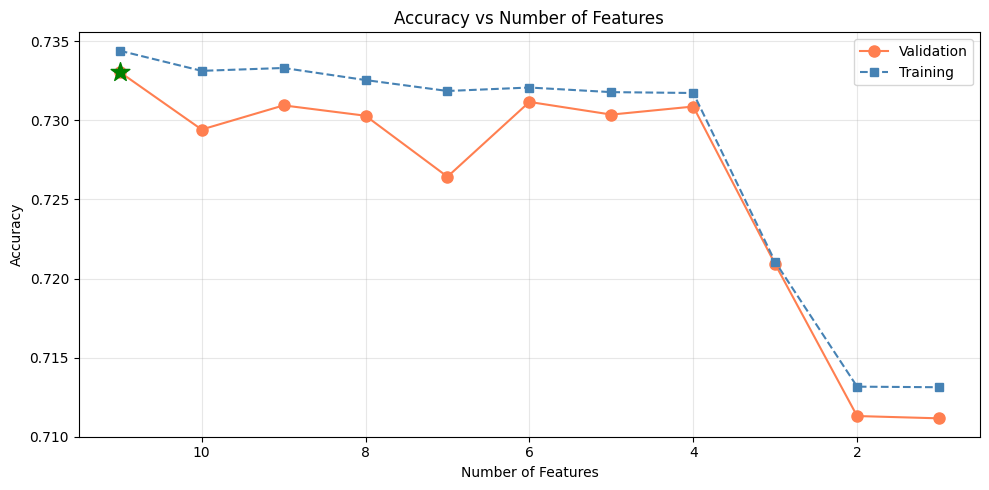

In [20]:
# plot how accuracy changes
plt.figure(figsize=(10, 5))

n_feats = [r['n_features'] for r in results]
val_accs = [r['val_acc'] for r in results]
train_accs = [r['train_acc'] for r in results]

plt.plot(n_feats, val_accs, 'o-', label='Validation', color='coral', markersize=8)
plt.plot(n_feats, train_accs, 's--', label='Training', color='steelblue', markersize=6)

plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Features')
plt.legend()
plt.gca().invert_xaxis()  # so it goes from 11 down to 1
plt.grid(True, alpha=0.3)

# mark the best one
best_idx = val_accs.index(max(val_accs))
plt.scatter([n_feats[best_idx]], [val_accs[best_idx]], color='green', s=200, zorder=5, marker='*')

plt.tight_layout()
plt.savefig('plots/feature_removal_accuracy.png', dpi=150)
plt.show()

## Part 3: Comparing original vs reduced model

In [21]:
# find which config was best
best_result = results[4]  # 7 features
original_result = results[0]

print("=" * 50)
print("COMPARISON")
print("=" * 50)
labels = ['Original\n(11 features)', 'Reduced\n(7 features)']
print(f"  Validation accuracy: {original_result['val_acc']*100:.2f}%")

print(f"\nReduced model ({best_result['n_features']} features):")
print(f"  Validation accuracy: {best_result['val_acc']*100:.2f}%")
print(f"  Features removed: {best_result['removed']}")

diff = best_result['val_acc'] - original_result['val_acc']
print(f"\nDifference: {diff*100:+.2f}%")

COMPARISON
  Validation accuracy: 73.31%

Reduced model (7 features):
  Validation accuracy: 72.64%
  Features removed: alco, smoke, gender, height

Difference: -0.66%


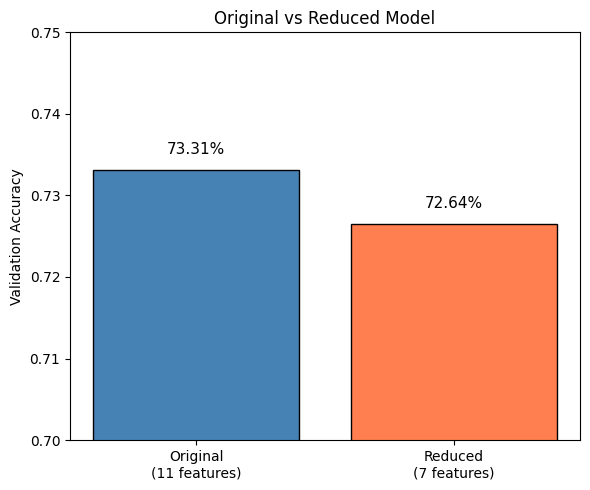

In [22]:
# bar chart comparison
plt.figure(figsize=(6, 5))

labels = ['Original\n(11 features)', f'Reduced\n({best_result["n_features"]} features)']
vals = [original_result['val_acc'], best_result['val_acc']]

bars = plt.bar(labels, vals, color=['steelblue', 'coral'], edgecolor='black')
plt.ylabel('Validation Accuracy')
plt.title('Original vs Reduced Model')

for bar, val in zip(bars, vals):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f'{val*100:.2f}%', ha='center', fontsize=11)

plt.ylim([0.70, 0.75])
plt.tight_layout()
plt.savefig('plots/original_vs_reduced.png', dpi=150)
plt.show()

## Summary

Looking at the results, the most important features for predicting cardiovascular
disease seem to be things like blood pressure and weight, which makes sense medically.
Some features like gender and smoking didnt help much on their own.

After removing the least important features one by one, I found that we can get
pretty similar accuracy with fewer features. This is useful because simpler models
are generally better.